In [1]:
import os,sys, re, time
from importlib import reload
import numpy as np
import pandas as pd

#import torch
print(os.getpid())
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares')

74794


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
import torch
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20210621-STORM6_lumencor_from_60_to_50' ## correction for STORM6

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
microscope_file = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters/microscope/storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2
-- 11 folders, 507 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Analysis/color_usage.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '647', 'hyb': 'H10M11'} 488


# Run segmentation

In [9]:

from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [10]:

for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id <400:
        continue
        

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='tissuenet')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
        
    #break

reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_400.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_400.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_400.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_400_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 0.327s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.843s.
-- corrected illu

- Loaded images for channels:['488', '405'] in 2.216s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.884s.
-- corrected illumination for channel 405 in 0.843s.
- Finished illumination correction in 1.752s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_403.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_403_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.374s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.872s.
-- corrected illumination for channel 405 in 0.845s.
- Finished illumination correction in 1.738s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_406.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_406_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.577s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.848s.
-- corrected illumination for channel 488 in 0.856s.
- Finished illumination correction in 

- Loaded images for channels:['647', '488'] in 1.448s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.756s.
-- corrected illumination for channel 488 in 0.764s.
- Finished illumination correction in 1.539s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.05  -0.74 -11.41] in 0.455s.
-- drift 1: [ -0.02  -0.69 -11.1 ] in 0.488s.
-- drift 2: [ -0.02  -0.62 -11.19] in 0.486s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 9.102s.
- Finished warp correction in

-- corrected illumination for channel 647 in 0.814s.
-- corrected illumination for channel 488 in 0.792s.
- Finished illumination correction in 1.625s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -0.74 -9.25] in 0.456s.
-- drift 1: [-0.03 -1.1  -9.22] in 0.497s.
-- drift 2: [-0.04 -0.61 -9.41] in 0.483s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 9.055s.
- Finished warp correction in 9.055s.
- apply microscope corrections
- run Cellpose segmentation in 282.311s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_412.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_413.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/2023062

-- corrected warp for channel 647 in 9.123s.
- Finished warp correction in 9.124s.
- apply microscope corrections
- run Cellpose segmentation in 167.855s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_415.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_416.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_416.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_416.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_416_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 1.905s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- S

- Loaded images for channels:['488', '405'] in 2.035s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.669s.
-- corrected illumination for channel 405 in 0.648s.
- Finished illumination correction in 1.338s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_419.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_419_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.495s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.550s.
-- corrected illumination for channel 405 in 0.538s.
- Finished illumination correction in 1.107s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_422.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_422_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.298s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.545s.
-- corrected illumination for channel 488 in 0.542s.
- Finished illumination correction in 

- Loaded images for channels:['647', '488'] in 1.409s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.545s.
-- corrected illumination for channel 488 in 0.541s.
- Finished illumination correction in 1.104s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -1.55 -1.07] in 0.459s.
-- drift 1: [-0.01 -1.01 -1.11] in 0.497s.
-- drift 2: [-0.03 -1.05 -1.15] in 0.488s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 8.830s.
- Finished warp correction in 8.830s.


-- corrected illumination for channel 647 in 0.548s.
-- corrected illumination for channel 488 in 0.543s.
- Finished illumination correction in 1.109s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -1.25 -2.93] in 0.459s.
-- drift 1: [-0.02 -1.17 -2.56] in 0.486s.
-- drift 2: [-0.03 -1.32 -2.54] in 0.488s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 8.844s.
- Finished warp correction in 8.844s.
- apply microscope corrections
- run Cellpose segmentation in 208.599s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_428.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_429.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/2023062

-- corrected warp for channel 647 in 8.823s.
- Finished warp correction in 8.823s.
- apply microscope corrections
- run Cellpose segmentation in 251.867s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_431.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_432.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_432.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_432.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_432_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 2.348s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- S

- Loaded images for channels:['488', '405'] in 1.740s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.648s.
-- corrected illumination for channel 405 in 0.651s.
- Finished illumination correction in 1.319s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_435.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_435_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.673s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.646s.
-- corrected illumination for channel 405 in 0.648s.
- Finished illumination correction in 1.314s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_438.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_438_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.464s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.647s.
-- corrected illumination for channel 488 in 0.647s.
- Finished illumination correction in 

- Loaded images for channels:['647', '488'] in 1.327s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.553s.
-- corrected illumination for channel 488 in 0.546s.
- Finished illumination correction in 1.118s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.66 -3.75] in 0.452s.
-- drift 1: [ 0.   -0.7  -3.42] in 0.478s.
-- drift 2: [ 0.   -0.73 -3.65] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 8.497s.
- Finished warp correction in 8.497s.


-- corrected illumination for channel 647 in 0.562s.
-- corrected illumination for channel 488 in 0.550s.
- Finished illumination correction in 1.131s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.81 -2.61] in 0.464s.
-- drift 1: [ 0.01 -0.95 -2.43] in 0.486s.
-- drift 2: [-0.02 -0.72 -2.55] in 0.492s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 8.453s.
- Finished warp correction in 8.453s.
- apply microscope corrections
- run Cellpose segmentation in 218.511s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_444.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_445.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/2023062

-- corrected warp for channel 647 in 8.902s.
- Finished warp correction in 8.902s.
- apply microscope corrections
- run Cellpose segmentation in 272.292s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_447.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_448.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_448.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_448.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_448_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 2.135s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- S

- Loaded images for channels:['488', '405'] in 2.177s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.569s.
-- corrected illumination for channel 405 in 0.543s.
- Finished illumination correction in 1.133s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_451.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_451_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.639s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.548s.
-- corrected illumination for channel 405 in 0.542s.
- Finished illumination correction in 1.114s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_454.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_454_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.397s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.552s.
-- corrected illumination for channel 488 in 0.559s.
- Finished illumination correction in 

- Loaded images for channels:['647', '488'] in 1.364s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.539s.
-- corrected illumination for channel 488 in 0.534s.
- Finished illumination correction in 1.092s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.200e+00  2.324e+01] in 0.479s.
-- drift 1: [-1.000e-02 -2.280e+00  2.327e+01] in 0.503s.
-- drift 2: [-1.000e-02 -2.210e+00  2.321e+01] in 0.507s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7

-- corrected illumination for channel 647 in 0.548s.
-- corrected illumination for channel 488 in 0.534s.
- Finished illumination correction in 1.101s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.110e+00 -2.068e+01] in 0.461s.
-- drift 1: [-2.000e-02 -2.110e+00 -2.066e+01] in 0.492s.
-- drift 2: [  0.    -2.04 -20.62] in 0.494s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7.921s.
- Finished warp correction in 7.921s.
- apply microscope corrections
- run Cellpose segmentation in 153.579s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_460.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_461.dax
PolyT and DAPI image: /lab/weissman_im

-- drift 2: [-0.02 -1.01 -9.  ] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7.996s.
- Finished warp correction in 7.996s.
- apply microscope corrections
- run Cellpose segmentation in 194.851s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_463.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_464.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_464.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_464.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_464_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- singl

- run Cellpose segmentation in 133.988s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_466.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_467.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_467.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_467.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_467_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 2.018s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 

- Loaded images for channels:['488', '405'] in 1.888s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.562s.
-- corrected illumination for channel 405 in 0.546s.
- Finished illumination correction in 1.129s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_470.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_470_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.385s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.604s.
-- corrected illumination for channel 405 in 0.532s.
- Finished illumination correction in 1.158s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_473.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_473_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.536s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.538s.
-- corrected illumination for channel 488 in 0.532s.
- Finished illumination correction in 

- Loaded images for channels:['647', '488'] in 1.385s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.537s.
-- corrected illumination for channel 488 in 0.529s.
- Finished illumination correction in 1.085s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -1.82 -0.95] in 0.469s.
-- drift 1: [-0.01 -2.11 -0.78] in 0.489s.
-- drift 2: [-0.01 -1.76 -0.94] in 0.492s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7.964s.
- Finished warp correction in 7.964s.


-- corrected illumination for channel 647 in 0.544s.
-- corrected illumination for channel 488 in 0.536s.
- Finished illumination correction in 1.097s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -1.66 -7.4 ] in 0.467s.
-- drift 1: [-0.01 -1.33 -7.06] in 0.485s.
-- drift 2: [ 0.   -1.19 -7.37] in 0.483s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7.925s.
- Finished warp correction in 7.925s.
- apply microscope corrections
- run Cellpose segmentation in 173.245s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_479.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_480.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/2023062

-- corrected warp for channel 647 in 7.925s.
- Finished warp correction in 7.925s.
- apply microscope corrections
- run Cellpose segmentation in 135.688s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_482.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_483.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_483.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_483.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_483_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 1.772s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- S

- Loaded images for channels:['488', '405'] in 1.897s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.584s.
-- corrected illumination for channel 405 in 0.547s.
- Finished illumination correction in 1.153s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_486.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_486_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.678s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 405 in 0.555s.
- Finished illumination correction in 1.137s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_489.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_489_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.365s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.556s.
-- corrected illumination for channel 488 in 0.569s.
- Finished illumination correction in 1.144s.
+ Calculate drift with fiducial_channel: 488


- Loaded images for channels:['647', '488'] in 1.365s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.557s.
-- corrected illumination for channel 488 in 0.549s.
- Finished illumination correction in 1.124s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.    -0.91 -10.49] in 0.457s.
-- drift 1: [  0.    -0.81 -10.41] in 0.482s.
-- drift 2: [  0.    -0.87 -10.4 ] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 7.996s.
- Finished warp correction in

-- corrected illumination for channel 647 in 0.553s.
-- corrected illumination for channel 488 in 0.553s.
- Finished illumination correction in 1.125s.
+ Calculate drift with fiducial_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -2.21 -8.35] in 0.484s.
-- drift 1: [ 0.   -2.28 -8.39] in 0.511s.
-- drift 2: [ 0.   -2.18 -8.3 ] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['647'], chromatic:[]
- Start 3D warpping for channels:['647'].
-- corrected warp for channel 647 in 8.004s.
- Finished warp correction in 8.004s.
- apply microscope corrections
- run Cellpose segmentation in 186.338s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_495.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_496.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/2023062

-- corrected warp for channel 647 in 7.965s.
- Finished warp correction in 7.965s.
- apply microscope corrections
- run Cellpose segmentation in 153.839s.
- save to file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/Segmentation/segmentation_label_498.npy
reference image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_499.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_499.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_499.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H0M1/Conv_zscan_499_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['488', '405'] in 1.930s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- S

- Loaded images for channels:['488', '405'] in 1.761s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 0.552s.
-- corrected illumination for channel 405 in 0.540s.
- Finished illumination correction in 1.112s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_502.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_502_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.387s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for 

-- corrected illumination for channel 488 in 0.555s.
-- corrected illumination for channel 405 in 0.550s.
- Finished illumination correction in 1.124s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_505.dax
- New save file: /lab/weissman_imaging/puzheng/Merfish_seq/20230623-KPtumor_lung_c2/H10M11/Conv_zscan_505_processed.hdf5
-- all used channels: ['750', '647', '488']
-- single image size: [  15 2048 2048]
- Loaded images for channels:['647', '488'] in 1.433s.
- Correct illumination for channels: ['647', '488']
-- Keep channels: ['647', '488'] for corr_illumination.
- Start illumination correction for channels:['647', '488'].
-- loading illumination correction profile from file:
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 647 in 0.562s.
-- corrected illumination for channel 488 in 0.553s.
- Finished illumination correction in 

<IPython.core.display.Javascript object>


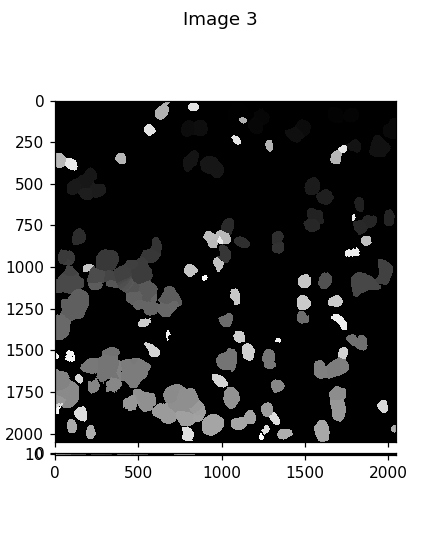

In [11]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


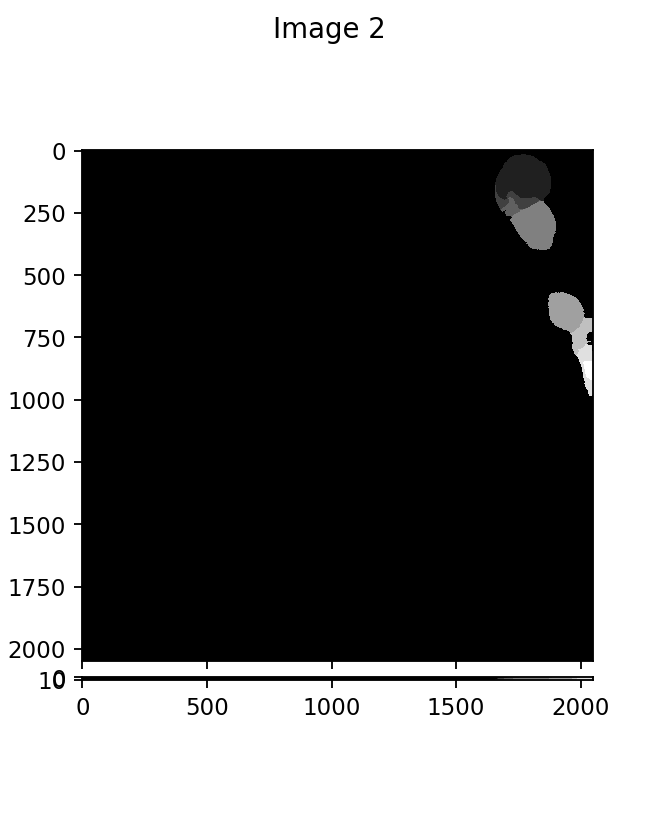

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')